In [1]:
import tensorflow as tf

In [2]:
#Model = tf.keras.Model
#layers = tf.keras.layers.De

In [3]:
import numpy as np
from validation import compute_f1
from keras.models import Model, load_model
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, \
    Flatten, concatenate
from preprocessing import readfile, createBatches, createMatrices, iterate_minibatches, addCharInformation, padding
from keras.utils import plot_model
from keras.initializers import RandomUniform
from keras.optimizers import SGD, Nadam

Using TensorFlow backend.


In [4]:
#data_train = readfile('./datasets/conll2002/esp.train')
#data_test_a = readfile('./datasets/conll2002/esp.testa')
#data_test_b = readfile('./datasets/conll2002/esp.testb')

In [5]:
#trainSentences = readfile("./datasets/corpus/conll2002/esp.train")
#devSentences = readfile("./datasets/corpus/conll2002/esp.testa")
#testSentences = readfile("./datasets/corpus/conll2002/esp.testb")

In [6]:
charSet = set()

In [7]:
class CNN_BLSTM(object):
    
    def __init__(self, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER):
        
        self.epochs = EPOCHS
        self.dropout = DROPOUT
        self.dropout_recurrent = DROPOUT_RECURRENT
        self.lstm_state_size = LSTM_STATE_SIZE
        self.conv_size = CONV_SIZE
        self.learning_rate = LEARNING_RATE
        self.optimizer = OPTIMIZER
        
        
    def loadData(self):
        """Load data and add character information"""
        self.trainSentences = readfile("./datasets/corpus/conll2002/esp.train")
        self.devSentences = readfile("./datasets/corpus/conll2002/esp.testa")
        self.testSentences = readfile("./datasets/corpus/conll2002/esp.testb")
        charSet = set()
        for dataset in [self.trainSentences, self.devSentences, self.testSentences]:
             for sentence in dataset:
                #print(sentence)
                for token, label in sentence:
                    for char1 in token:
                        charSet.add(char1)
        
        self.charList = list(charSet)
        

    def addCharInfo(self):
        # format: [['EU', ['E', 'U'], 'B-ORG\n'], ...]
        self.trainSentences = addCharInformation(self.trainSentences)
        self.devSentences = addCharInformation(self.devSentences)
        self.testSentences = addCharInformation(self.testSentences)

    def embed(self):
        """Create word- and character-level embeddings"""

        labelSet = set()
        words = {}
        charSet = set()
        # unique words and labels in data  
        for dataset in [self.trainSentences, self.devSentences, self.testSentences]:
            for sentence in dataset:
                for token, char, label in sentence:
                    # token ... token, char ... list of chars, label ... BIO labels   
                    labelSet.add(label)
                    #charSet.add(char)
                    words[token.lower()] = True

        # mapping for labels
        self.label2Idx = {}
        for label in labelSet:
            self.label2Idx[label] = len(self.label2Idx)

        # mapping for token cases
        case2Idx = {'numeric': 0, 'allLower': 1, 'allUpper': 2, 'initialUpper': 3, 'other': 4, 'mainly_numeric': 5,
                    'contains_digit': 6, 'PADDING_TOKEN': 7}
        self.caseEmbeddings = np.identity(len(case2Idx), dtype='float32')  # identity matrix used 

        # read Wikipedia2Vec word embeddings
        word2Idx = {}
        self.wordEmbeddings = []

        fEmbeddings = open("./datasets/Embeddings/eswiki_20180420_100d.txt", encoding="utf-8")
        fEmbeddings.readline()

        # loop through each word in embeddings
        for line in fEmbeddings:
            split = line.strip().split(" ")
            word = split[0]  # embedding word entry

            if len(word2Idx) == 0:  # add padding+unknown
                word2Idx["PADDING_TOKEN"] = len(word2Idx)
                vector = np.zeros(len(split) - 1)  # zero vector for 'PADDING' word
                self.wordEmbeddings.append(vector)

                word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
                vector = np.random.uniform(-0.25, 0.25, len(split) - 1)
                self.wordEmbeddings.append(vector)

            if split[0].lower() in words:
                vector = np.array([float(num) for num in split[1:]])
                self.wordEmbeddings.append(vector)  # word embedding vector
                word2Idx[split[0]] = len(word2Idx)  # corresponding word dict

        self.wordEmbeddings = np.array(self.wordEmbeddings)

        # dictionary of all possible characters
        self.char2Idx = {"PADDING": 0, "UNKNOWN": 1}
        #charList=list(charSet)
        for c in self.charList:
        #for c in " 0123456789aábcdeéfghiíjklmnñoópqrstuúüvwxyzAÁBCDEÉFGHIÍJKLMNÑOÓPQRSTUÚÜVWXYZ.·,-_()[]{}¡!¿?:;#'\"/\\%$`&=*+@^~|<>":
            self.char2Idx[c] = len(self.char2Idx)

        # format: [[wordindices], [caseindices], [padded word indices], [label indices]]
        self.train_set = padding(createMatrices(self.trainSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
        self.dev_set = padding(createMatrices(self.devSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
        self.test_set = padding(createMatrices(self.testSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
        print(self.char2Idx)
        self.idx2Label = {v: k for k, v in self.label2Idx.items()}
        
    def createBatches(self):
        """Create batches"""
        self.train_batch, self.train_batch_len = createBatches(self.train_set)
        self.dev_batch, self.dev_batch_len = createBatches(self.dev_set)
        self.test_batch, self.test_batch_len = createBatches(self.test_set)
        
    def tag_dataset(self, dataset, model):
        """Tag data with numerical values"""
        correctLabels = []
        predLabels = []
        for i, data in enumerate(dataset):
            tokens, casing, char, labels = data
            tokens = np.asarray([tokens])
            casing = np.asarray([casing])
            char = np.asarray([char])
            pred = model.predict([tokens, casing, char], verbose=False)[0]
            pred = pred.argmax(axis=-1)  # Predict the classes
            correctLabels.append(labels)
            predLabels.append(pred)
        return predLabels, correctLabels
    
    def buildModel(self):
        """Model layers"""

        # character input
        character_input = Input(shape=(None, 102,), name="Character_input")
        embed_char_out = TimeDistributed(
            Embedding(len(self.char2Idx), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name="Character_embedding")(
            character_input)

        dropout = Dropout(self.dropout)(embed_char_out)

        # CNN
        conv1d_out = TimeDistributed(Conv1D(kernel_size=self.conv_size, filters=30, padding='same', activation='tanh', strides=1), name="Convolution")(dropout)
        maxpool_out = TimeDistributed(MaxPooling1D(102), name="Maxpool")(conv1d_out)
        char = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
        char = Dropout(self.dropout)(char)

        # word-level input
        words_input = Input(shape=(None,), dtype='int32', name='words_input')
        words = Embedding(input_dim=self.wordEmbeddings.shape[0], output_dim=self.wordEmbeddings.shape[1], weights=[self.wordEmbeddings],
                          trainable=False)(words_input)

        # case-info input
        casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
        casing = Embedding(output_dim=self.caseEmbeddings.shape[1], input_dim=self.caseEmbeddings.shape[0], weights=[self.caseEmbeddings],
                           trainable=False)(casing_input)

        # concat & BLSTM
        output = concatenate([words, casing, char])
        output = Bidirectional(LSTM(self.lstm_state_size, 
                                    return_sequences=True, 
                                    dropout=self.dropout,                        # on input to each LSTM block
                                    recurrent_dropout=self.dropout_recurrent     # on recurrent input signal
                                   ), name="BLSTM")(output)
        output = TimeDistributed(Dense(len(self.label2Idx), activation='softmax'),name="Softmax_layer")(output)

        # set up model
        self.model = Model(inputs=[words_input, casing_input, character_input], outputs=[output])
        
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=self.optimizer)
        
        self.init_weights = self.model.get_weights()
        
        plot_model(self.model, to_file='model.png')
        
        print("Model built. Saved model.png\n")
        
    def train(self):
        """Default training"""

        self.f1_test_history = []
        self.f1_dev_history = []

        for epoch in range(self.epochs):    
            print("Epoch {}/{}".format(epoch, self.epochs))
            for i,batch in enumerate(iterate_minibatches(self.train_batch,self.train_batch_len)):
                labels, tokens, casing,char = batch       
                self.model.train_on_batch([tokens, casing,char], labels)

            # compute F1 scores
            predLabels, correctLabels = self.tag_dataset(self.test_batch, self.model)
            pre_test, rec_test, f1_test = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_test_history.append(f1_test)
            print("f1 test ", round(f1_test, 4))

            predLabels, correctLabels = self.tag_dataset(self.dev_batch, self.model)
            pre_dev, rec_dev, f1_dev = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_dev_history.append(f1_dev)
            print("f1 dev ", round(f1_dev, 4), "\n")
            
        print("Final F1 test score: ", f1_test)
            
        print("Training finished.")
            
        # save model
        self.modelName = "{}_{}_{}_{}_{}_{}_{}".format(self.epochs, 
                                                        self.dropout, 
                                                        self.dropout_recurrent, 
                                                        self.lstm_state_size,
                                                        self.conv_size,
                                                        self.learning_rate,
                                                        self.optimizer.__class__.__name__
                                                       )
        
        modelName = self.modelName + ".h5"
        self.model.save(modelName)
        print("Model weights saved.")
        
        self.model.set_weights(self.init_weights)  # clear model
        print("Model weights cleared.")

    def writeToFile(self):
        """Write output to file"""

        # .txt file format
        # [epoch  ]
        # [f1_test]
        # [f1_dev ]
        
        output = np.matrix([[int(i) for i in range(self.epochs)], self.f1_test_history, self.f1_dev_history])

        fileName = self.modelName + ".txt"
        with open(fileName,'wb') as f:
            for line in output:
                np.savetxt(f, line, fmt='%.5f')
                
        print("Model performance written to file.")

    print("Class initialised.")

Class initialised.


In [8]:

"""Set parameters"""

EPOCHS = 80               # paper: 80
DROPOUT = 0.5             # paper: 0.68
DROPOUT_RECURRENT = 0.25  # not specified in paper, 0.25 recommended
LSTM_STATE_SIZE = 275     # paper: 275
CONV_SIZE = 3             # paper: 3
LEARNING_RATE = 0.0105    # paper 0.0105
OPTIMIZER = Nadam()       # paper uses SGD(lr=self.learning_rate), Nadam() recommended

In [9]:
cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
#cnn_blstm.createBatches()
#cnn_blstm.buildModel()
#cnn_blstm.train()
#cnn_blstm.writeToFile()

{'PADDING': 0, 'UNKNOWN': 1, '?': 2, 'b': 3, 'm': 4, 'U': 5, 't': 6, '6': 7, 'R': 8, 'M': 9, '·': 10, 'Q': 11, 'G': 12, 'T': 13, 'P': 14, 'e': 15, 'c': 16, 'é': 17, '.': 18, 'h': 19, 'S': 20, 'p': 21, '9': 22, '&': 23, '1': 24, 'ü': 25, 'z': 26, 'í': 27, 'u': 28, "'": 29, 'B': 30, 'w': 31, 'ú': 32, 'ó': 33, 'J': 34, 'E': 35, 'g': 36, 'y': 37, '0': 38, '=': 39, '+': 40, 'X': 41, ')': 42, '8': 43, '4': 44, '3': 45, 'I': 46, 'O': 47, 'v': 48, 'à': 49, 'C': 50, 'Ñ': 51, 'r': 52, 'W': 53, 'n': 54, 'L': 55, '@': 56, '!': 57, ',': 58, 'N': 59, 'F': 60, 'j': 61, 'q': 62, '(': 63, 'l': 64, '7': 65, 'á': 66, 'Y': 67, 'i': 68, 'K': 69, '-': 70, '5': 71, '¿': 72, '"': 73, 'o': 74, 'H': 75, ':': 76, '/': 77, 'D': 78, ';': 79, 'x': 80, 'V': 81, '%': 82, 'k': 83, 'Z': 84, 's': 85, 'ñ': 86, 'a': 87, '¡': 88, '2': 89, 'f': 90, 'A': 91, 'd': 92}


In [10]:
cnn_blstm.idx2Label

{0: 'O\n',
 1: 'I-ORG\n',
 2: 'I-MISC\n',
 3: 'B-PER\n',
 4: 'B-ORG\n',
 5: 'I-PER\n',
 6: 'B-MISC\n',
 7: 'B-LOC\n',
 8: 'I-LOC\n'}

In [12]:
import pandas as pd

In [13]:
df = pd.DataFrame.from_dict(cnn_blstm.idx2Label, orient='index').reset_index()

In [14]:
df

,index,0
0,0,O\n
1,1,I-ORG\n
2,2,I-MISC\n
3,3,B-PER\n
4,4,B-ORG\n
5,5,I-PER\n
6,6,B-MISC\n
7,7,B-LOC\n
8,8,I-LOC\n


In [15]:
df.columns = ['index', 'label']

In [16]:
df.to_pickle('idx2label.pkl', 'gzip')

In [10]:
cnn_blstm.createBatches()


In [11]:
cnn_blstm.buildModel()

Model built. Saved model.png



In [12]:
cnn_blstm.train()

Epoch 0/80


C:\Users\Camilo\Anaconda3\envs\thesis\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


f1 test  0.5104
f1 dev  0.422 

Epoch 1/80
f1 test  0.546
f1 dev  0.457 

Epoch 2/80
f1 test  0.5981
f1 dev  0.5209 

Epoch 3/80
f1 test  0.6775
f1 dev  0.6028 

Epoch 4/80
f1 test  0.699
f1 dev  0.6248 

Epoch 5/80
f1 test  0.6748
f1 dev  0.5767 

Epoch 6/80
f1 test  0.7156
f1 dev  0.6235 

Epoch 7/80
f1 test  0.709
f1 dev  0.6206 

Epoch 8/80
f1 test  0.6911
f1 dev  0.611 

Epoch 9/80
f1 test  0.6707
f1 dev  0.5959 

Epoch 10/80
f1 test  0.7368
f1 dev  0.6801 

Epoch 11/80
f1 test  0.711
f1 dev  0.6356 

Epoch 12/80
f1 test  0.7178
f1 dev  0.6545 

Epoch 13/80
f1 test  0.7457
f1 dev  0.7008 

Epoch 14/80
f1 test  0.7378
f1 dev  0.6863 

Epoch 15/80
f1 test  0.7463
f1 dev  0.7033 

Epoch 16/80
f1 test  0.7535
f1 dev  0.7053 

Epoch 17/80
f1 test  0.7662
f1 dev  0.726 

Epoch 18/80
f1 test  0.7812
f1 dev  0.7374 

Epoch 19/80
f1 test  0.714
f1 dev  0.68 

Epoch 20/80
f1 test  0.7608
f1 dev  0.7274 

Epoch 21/80
f1 test  0.7884
f1 dev  0.7504 

Epoch 22/80
f1 test  0.7797
f1 dev  0.7456

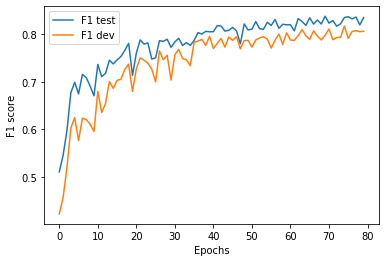

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cnn_blstm.f1_test_history, label = "F1 test")
plt.plot(cnn_blstm.f1_dev_history, label = "F1 dev")
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

In [14]:
plt.show()